![](./figures/Logo.PNG)

## In this part of the tutorial, you will
* analyse dynamic model outputs visually
* analyse the model residuals (the difference between observed and simulated)

- - -

# 2a - Visual Model Output Inspection

- - -

## 1. Model Outputs

To understand the quality of our model, we mainly focus on the model output for different parameter sets and reference observations.

1. A key initial step in model output analysis is **visual inspection** of the simulated time series using various plots. Where observations are available, these can be compared with the simulation results. You will do this in the first blue box. 

2. When data does not follow a normal distribution, we can ues the [**Box-Cox Transformation**](https://doi.org/10.1111/j.2517-6161.1964.tb00553.x          ). The resulting time series highlight different aspects, that were not visible beforehand. You will do this in the second blue box.

4. Using **scatterplots** of observed values against simulated results we can check for sections in which the model over- or underpredicts the observations. Suprisingly, you will do this in the third blue box.

5. Importantly, we can study the residuals of a model. The [**residual**](https://en.wikipedia.org/wiki/Errors_and_residuals), quantifying where the model results are close and far from the observed values, is another helpful tool.

---

## 2. Visual Inspection of Model Output

**Import packages**

In [1]:
import sys
sys.path.append('src/')
import scipy
import random
import HBV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import interact, Dropdown

In [2]:
def hbv(par, precip, temp, evap):
    # Run HBV snow routine
    p_s, _, _ = HBV.snow_routine(par[:4], temp, precip)
    # Run HBV runoff simulation
    Case = 1 # for now we assume that the preferred path in the upper zone is runoff (Case = 1), it can be set to percolation (Case = 2)
    ini = np.array([0,0,0]) # initial state
    runoff_sim, _, _ = HBV.hbv_sim(par[4:], p_s, evap, Case, ini)
    return runoff_sim

### 2.1. Read Catchment Data, Prepare Model Input
<span style="color:crimson">Remember to execute all cells below after changing the catchment!</span>

In [3]:
# DO NOT ALTER! code to select the catchment

l_catchment_names = ["Medina River, TX, USA", "Siletz River, OR, USA", "Trout River, BC, Canada"]
l_catchment_filenames = ["camels_08178880", "camels_14305500", "hysets_10BE007"]

catchment_dropdown = Dropdown(options=zip(l_catchment_names, l_catchment_filenames),
                              value=l_catchment_filenames[0],
                              description="Catchment:",
                              disabled=False)
display(catchment_dropdown)

Dropdown(description='Catchment:', options=(('Medina River, TX, USA', 'camels_08178880'), ('Siletz River, OR, …

In [4]:
# get the name of the catchment from the dropdown
catchment_file = catchment_dropdown.value
catchment_name = l_catchment_names[l_catchment_filenames.index(catchment_file)]
print(f"Catchment Name: {catchment_name} ({catchment_file})")

start_date = '2002-10-01'
end_date   = '2003-09-30'

df_obs         = pd.read_csv(f"data/{catchment_file}.csv")          # load the catchment data   
df_obs.date    = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')  # convert date string to datetime 
df_obs         = df_obs.set_index('date')                           # use date as index
df_obs         = df_obs[start_date:end_date]                        # select between start date and end dat
df_obs["date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y')) # again, add a date column for plotting 
df_obs         = df_obs.reset_index(drop=True)         
df_obs         = df_obs[["snow_depth_water_equivalent_mean", "total_precipitation_sum","potential_evaporation_sum", "streamflow", "temperature_2m_mean", "date"]]
df_obs.columns = ["Snow [mm/day]", "P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]", "Date"]

# select these columns for acess in the model
P, evap, temp  = df_obs[["P [mm/day]", "PET [mm/day]", "T [C]"]].to_numpy().T

# read calibrated parameters
df_par   = pd.read_csv("data/calibrated_parameters - HBV.csv")
df_par   = df_par[df_par["catchment_name"] == catchment_name]       # only select the parameters for this catchment
obj_funs = df_par["objective_function"]                             # extract obj_funs for which there are parameters

Catchment Name: Medina River, TX, USA (camels_08178880)


### 2.2. Comparing Simulated and Observed Hydrographs

/Users/david/Documents/Potsdam/PhD/Teaching/Environmental-Modelling-Process/GEE-SE03-T03/src/HBV.py:245: RuntimeWarning: divide by zero encountered in scalar divide
  EA[t] = ept[t] * min(SM_dummy/(FC*LP), 1) # Compute the evaporation
/Users/david/Documents/Potsdam/PhD/Teaching/Environmental-Modelling-Process/GEE-SE03-T03/src/HBV.py:245: RuntimeWarning: invalid value encountered in scalar divide
  EA[t] = ept[t] * min(SM_dummy/(FC*LP), 1) # Compute the evaporation


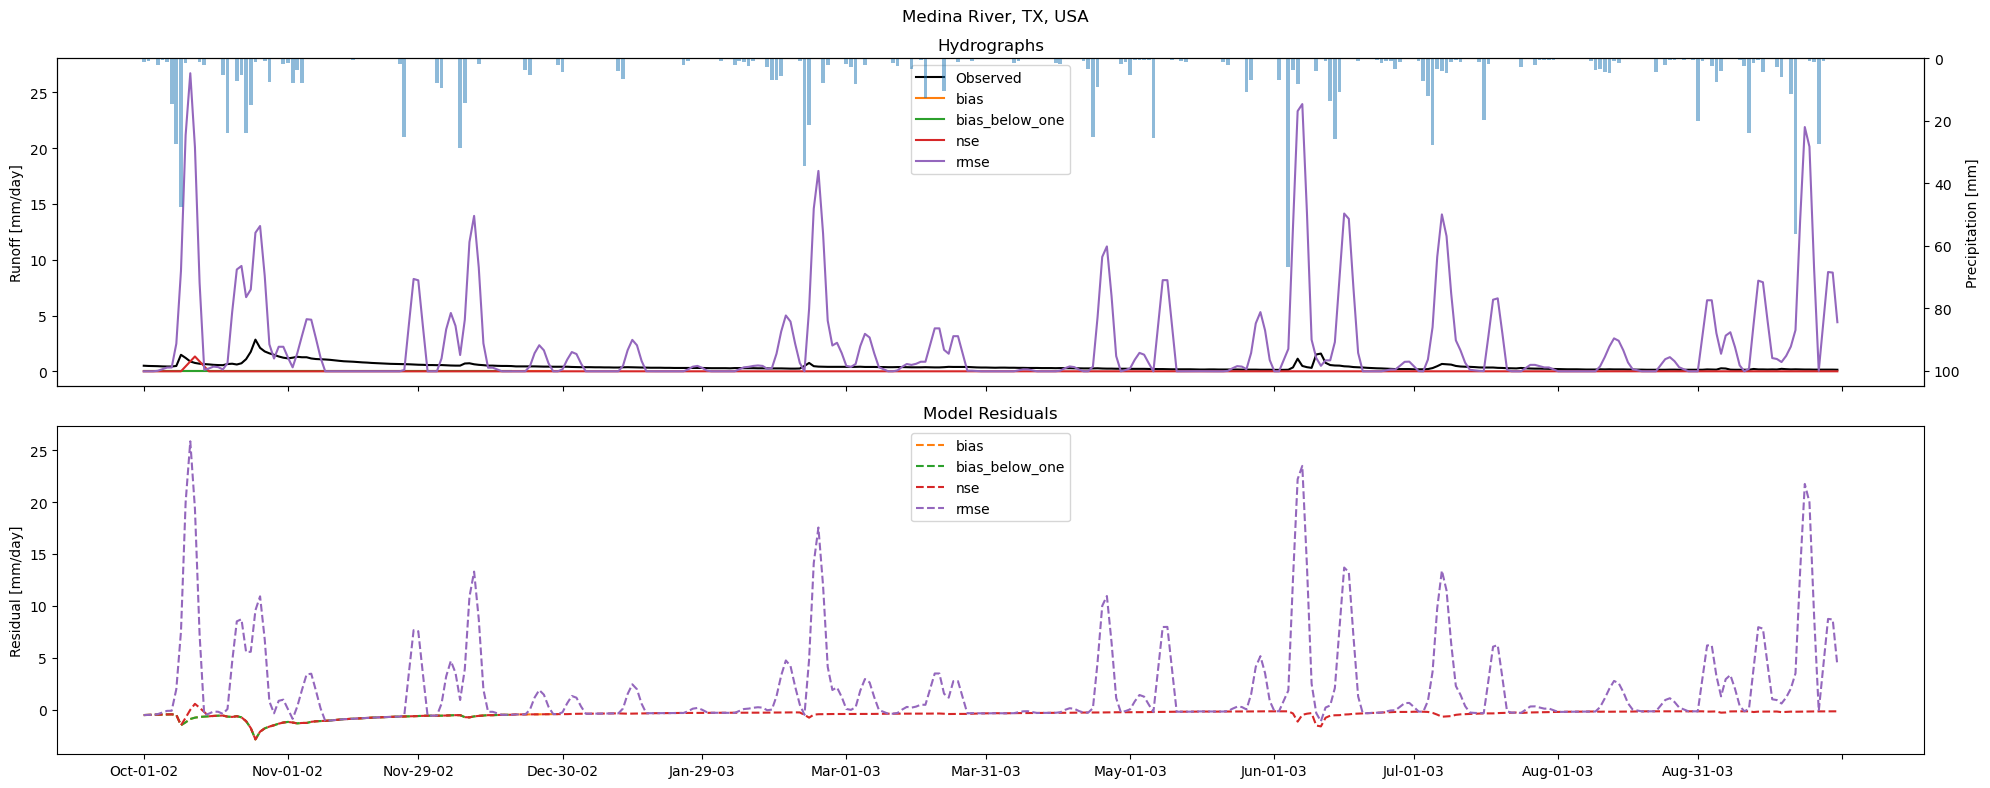

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

# plot the observed data
axs[0].plot(df_obs["Date"], df_obs["Q [mm/day]"], color="black", label="Observed")
axs[0].xaxis.set_major_locator(mdates.MonthLocator())

# plot precipitation on inverted axis
axi = axs[0].twinx()
axi.invert_yaxis()
axi.bar(df_obs["Date"], P, alpha=0.5)
axi.set_ylabel("Precipitation [mm]")
axi.set_ylim(axi.get_ylim()[0]*1.5, 0)

for i, obj_fun in enumerate(obj_funs):

    # extract parameters and run HBV
    params = df_par[df_par.objective_function == obj_fun].iloc[0,2:].to_numpy()
    Q_sim  = hbv(params, P, temp, evap)

    # plot the simulated hydrograph and model residuals
    axs[0].plot(df_obs["Date"], Q_sim, color=f"C{i + 1}", label=obj_fun)
    axs[1].plot(df_obs["Date"], Q_sim - df_obs["Q [mm/day]"], color=f"C{i + 1}", ls="--", label=obj_fun)

fig.suptitle(catchment_name)
axs[0].set_title(f"Hydrographs")
axs[1].set_title(f"Model Residuals")
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("Runoff [mm/day]")
axs[1].set_ylabel("Residual [mm/day]")

plt.tight_layout()
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue;">
    <h4><span>&#129300 </span>Your Turn I: Comparing Simulated and Observed Hydrographs</h4>
    <ol>
        <li>What parts of the time series do the different model runs reproduce well or poorly? In other words: which features of the hydrograph do they capture well?</li>
        <li>How could you adjust these plots to see other aspects of model performance?</li>
        <li>What other aspects of model performance might be interesting but not captured in this plot?</li>
    </ol>
</div>

### 2.3. Using the Box-Cox Transformation

The [Box-Cox transformation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) is a family of power transformations used to stabilize variance and make data more normally distributed. It is particularly useful when dealing with data that shows heteroscedasticity or non-normality. The Box-Cox transformation is used to stabilize variance and improve the normality of data, which can enhance the performance of statistical methods that assume normally distributed errors.

The transformation is defined as:

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\log(y) & \text{if } \lambda = 0
\end{cases}
$$

where:
- $y$ is the original data value,
- $\lambda$ (lambda) is the transformation parameter,
- $y(\lambda)$ is the transformed data value.

The parameter $\lambda$ is typically chosen to maximize the log-likelihood function of the transformed data under the assumption of normality. Common values include $\lambda = 1$ (no transformation), $\lambda = 0.5$ (square root transformation), and $\lambda = -1$ (reciprocal transformation).

In [6]:
@interact(lmbda = (0.0, 1.0, 0.01))
def plot_hydrographs(lmbda = 0.15):

    fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

    # plot the observed data using Box-Cox transformation
    axs[0].plot(df_obs["Date"], scipy.special.boxcox1p(df_obs["Q [mm/day]"], lmbda), color="black", label="Observed")
    axs[0].xaxis.set_major_locator(mdates.MonthLocator())
    
    # plot precipitation on inverted axis
    axi = axs[0].twinx()
    axi.invert_yaxis()
    axi.bar(df_obs["Date"], P, alpha=0.5)
    axi.set_ylabel("Precipitation [mm]")
    axi.set_ylim(axi.get_ylim()[0]*1.5, 0)
    
    for i, obj_fun in enumerate(obj_funs):
    
        # extract parameters and run HBV
        params = df_par[df_par.objective_function == obj_fun].iloc[0,2:].to_numpy()
        Q_sim  = hbv(params, P, temp, evap)
        Q_sim  = scipy.special.boxcox1p(Q_sim, lmbda)
    
        # plot the simulated hydrograph and model residuals
        axs[0].plot(df_obs["Date"], Q_sim, color=f"C{i + 1}", label=obj_fun)
        axs[1].plot(df_obs["Date"], Q_sim - df_obs["Q [mm/day]"], color=f"C{i + 1}", ls="--", label=obj_fun)
    
    fig.suptitle(catchment_name)
    axs[0].set_title(f"Hydrographs (Box-Cox transformed)")
    axs[1].set_title(f"Model Residuals (Box-Cox transformed)")
    axs[0].legend()
    axs[1].legend()
    axs[0].set_ylabel("Runoff [mm/day]")
    axs[1].set_ylabel("Residual [mm/day]")
    
    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.15, description='lmbda', max=1.0, step=0.01), Output()), _dom_classe…

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue;">
    <h4><span>&#129300 </span>Your Turn II: Box-Cox Transformation</h4>
    <ol>
        <li>What benefits does the Box-Cox transformation offer?</li>
        <li>What is an optimal lambda-value for the Box-Cox transformation?</li>
    </ol>
</div>

### 2.4. Using scatter plots of observed values against simulated values to determine over- and underprediction

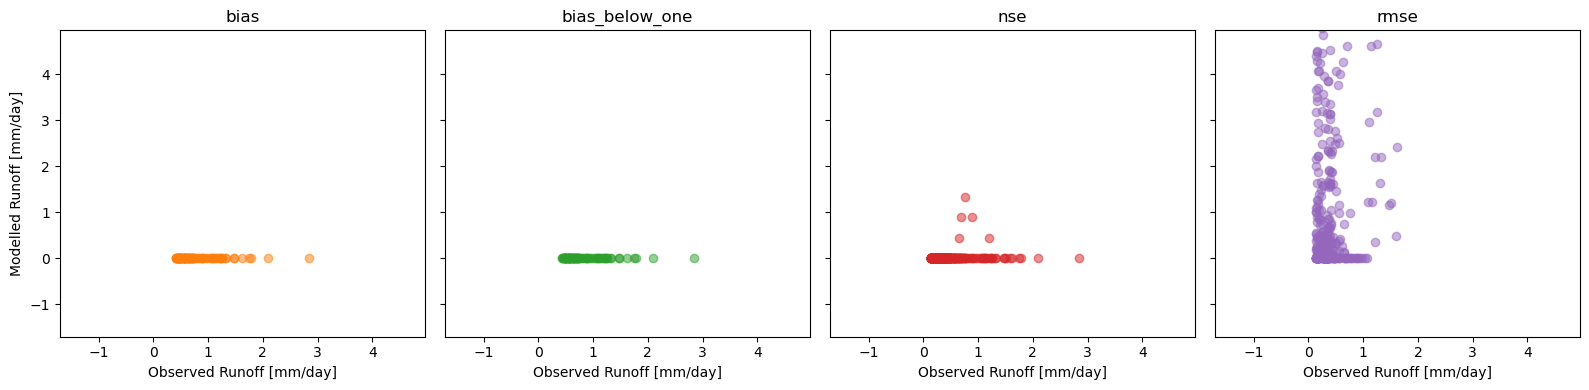

In [7]:
fig, axs = plt.subplots(1, len(obj_funs), figsize=(4*len(obj_funs), 4), squeeze=False, sharey=True, sharex=True)

for i, (obj_fun, ax) in enumerate(zip(obj_funs, axs[0])):

    # extract parameters and run HBV
    params = df_par[df_par.objective_function == obj_fun].iloc[0,2:].to_numpy()
    Q_sim  = hbv(params, P, temp, evap)

    # scatter plot simulated vs. observed hydrographs
    ax.scatter(df_obs["Q [mm/day]"], Q_sim, alpha=0.5, color=f"C{i + 1}")
    lims = np.array([ax.get_xlim(), ax.get_ylim()]).max(axis=0) + np.array([-0.5, 0.5]) # perfect fit would have 45° angle
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    ax.set_title(obj_fun)
    ax.set_xlabel("Observed Runoff [mm/day]")

axs[0, 0].set_ylabel("Modelled Runoff [mm/day]")

plt.tight_layout()
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue">
    <h4><span>&#129300 </span>Your Turn III: Using scatter plots to determine over- and underprediction</h4>
    The above plots show scatter plots of observed against simulated runoff. The simulation results were calibrated differently.
    <ol>
        <li>What does each individual scatter plot tell you about the model performance in simulating runoff? Are low flow periods and peak flows accurately simulated?</li>
        <li>Can you think of ways to adjust the scatterplot so that they could be even more informative? Implement your idea in the code!</li>
    </ol>
</div>

### 2.5. Analysing Residuals

In the context of the HyMOD hydrological model, model residuals represent the differences between observed streamflow values and those predicted by the model. They are a measure of the model's performance in capturing the actual hydrological behavior.

For a given time step, the residual is calculated as:

$$
\text{Residual} = \text{Observed Streamflow} - \text{Predicted Streamflow}
$$

Analyzing residuals helps assess the accuracy of the HyMOD model. Ideally, residuals should be randomly distributed with no discernible pattern, indicating that the model effectively represents the underlying hydrological processes. Patterns or systematic deviations in residuals may suggest areas where the model could be improved, such as adjustments to parameters or incorporation of additional factors.

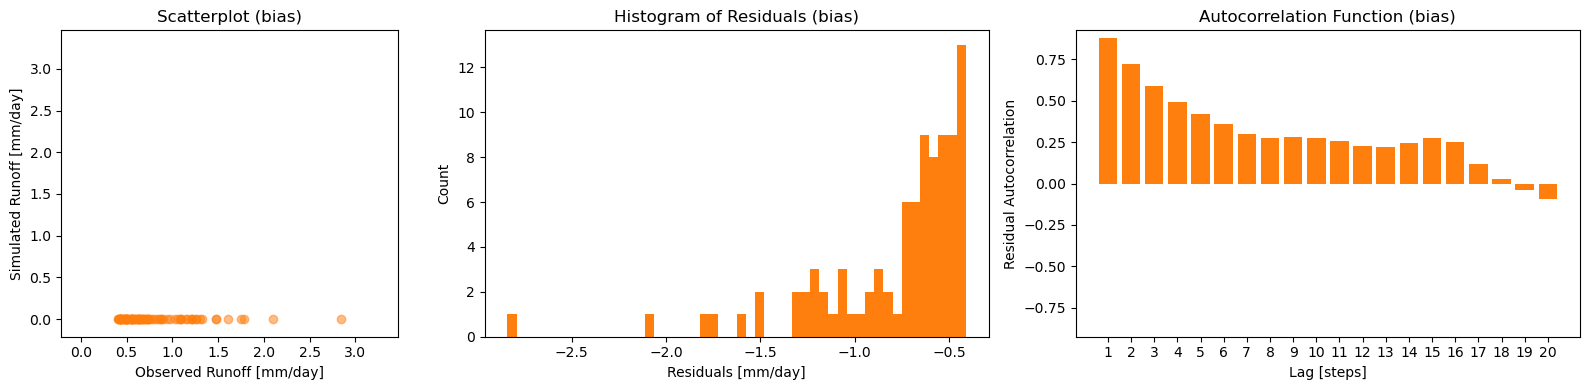

/Users/david/Documents/Potsdam/PhD/Teaching/Environmental-Modelling-Process/GEE-SE03-T03/src/HBV.py:245: RuntimeWarning: divide by zero encountered in scalar divide
  EA[t] = ept[t] * min(SM_dummy/(FC*LP), 1) # Compute the evaporation
/Users/david/Documents/Potsdam/PhD/Teaching/Environmental-Modelling-Process/GEE-SE03-T03/src/HBV.py:245: RuntimeWarning: invalid value encountered in scalar divide
  EA[t] = ept[t] * min(SM_dummy/(FC*LP), 1) # Compute the evaporation


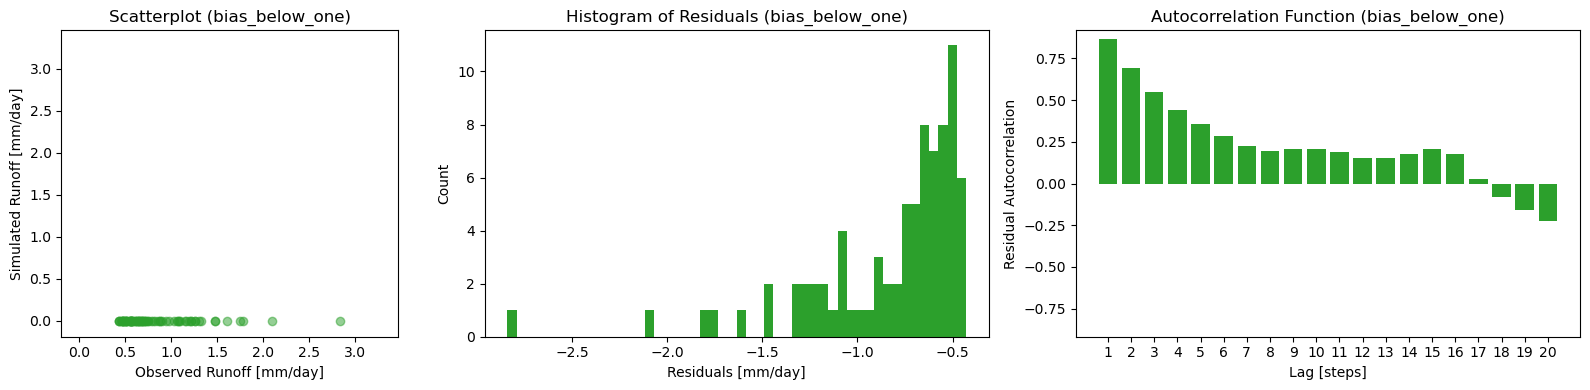

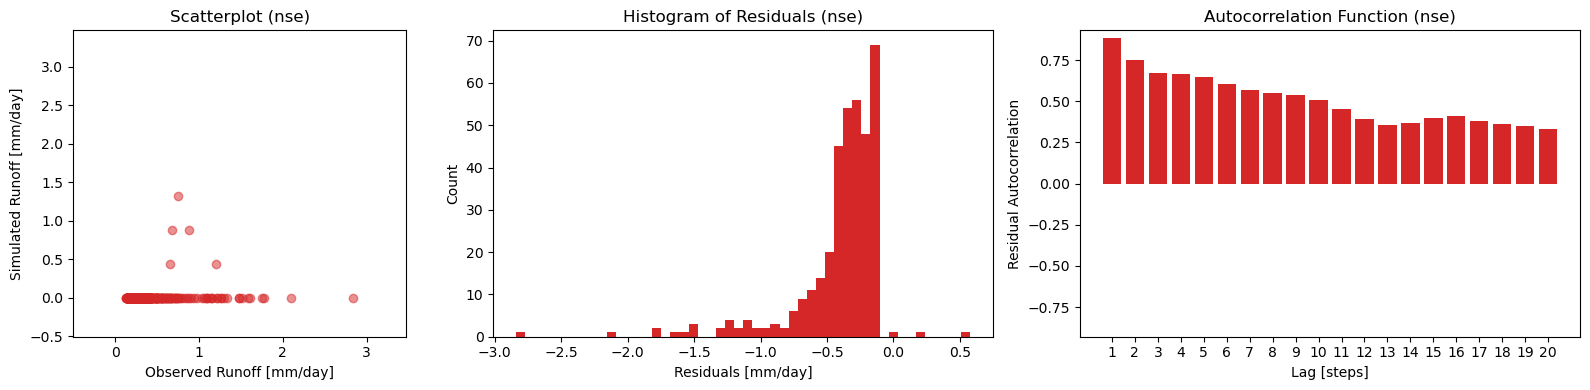

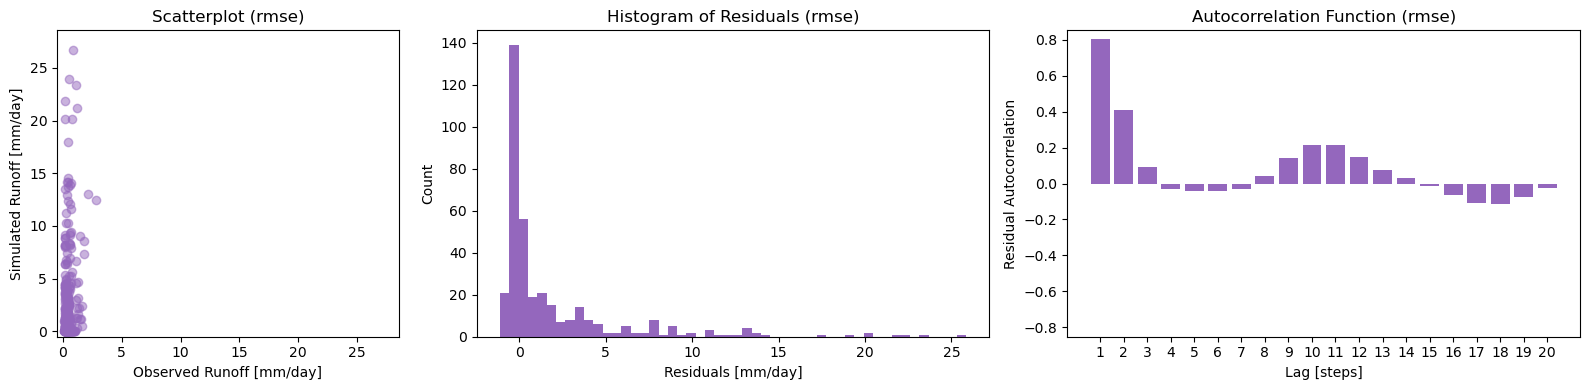

In [8]:
for i, obj_fun in enumerate(obj_funs):

    fig, axs = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={"width_ratios": [1, 1.5, 1.5]})
    
    # extract parameters and run HBV
    params = df_par[df_par.objective_function == obj_fun].iloc[0,2:].to_numpy()
    Q_sim  = hbv(params, P, temp, evap)

    # calculate autorcorrelation of residuals (pearson correlation with shifted self)
    lags      = range(1, 21)
    residuals = pd.Series(Q_sim - df_obs["Q [mm/day]"])
    autocorr  = [residuals.autocorr(lag) for lag in lags]
    
    # PLOT 1: scatter plot simulated vs. observed hydrographs
    axs[0].scatter(df_obs["Q [mm/day]"], Q_sim, alpha=0.5, color=f"C{i + 1}")
    lims = np.array([axs[0].get_xlim(), axs[0].get_ylim()]).max(axis=0) + np.array([-0.5, 0.5]) # perfect fit would have 45° angle
    axs[0].set_title(f"Scatterplot ({obj_fun})")
    axs[0].set_xlim(lims)
    axs[0].set_ylim(lims)
    axs[0].set_xlabel("Observed Runoff [mm/day]")
    axs[0].set_ylabel("Simulated Runoff [mm/day]")
    
    # PLOT 2: histogram of residuals
    axs[1].hist(Q_sim - df_obs["Q [mm/day]"], color=f"C{i + 1}", bins=50)
    axs[1].set_title(f"Histogram of Residuals ({obj_fun})")
    axs[1].set_xlabel("Residuals [mm/day]")
    axs[1].set_ylabel("Count")
    
    # PLOT 3: autocorrelation
    axs[2].bar(lags, autocorr, color=f"C{i + 1}")
    lim = np.abs(np.array(axs[2].get_ylim())).max()
    axs[2].set_title(f"Autocorrelation Function ({obj_fun})")
    axs[2].set_ylim(-lim, lim)
    axs[2].set_xticks(lags, lags)
    axs[2].set_xlabel("Lag [steps]")
    axs[2].set_ylabel("Residual Autocorrelation")
    
    plt.tight_layout()
    plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue">
    <h4><span>&#129300 </span>Your Turn IV: Analysing Residuals</h4>
    <ol>
        <li>What can you learn from these residual scatter plot?</li>
        <li>What can you learn from the residual distribution in general?</li>
        <li>What can you learn from the residual <a href="https://en.wikipedia.org/wiki/Autocorrelation">autocorrelation?</a></li>
    </ol>
</div>